# Kuala Lumpur neighborhoods analysis

#Introduction/Business Problem
In this project we will compare different neighborhoods of the KL city based on property prices, types and venues around that neighborhood using machine learning clustering algorithms.

There are many reasons people relocate within city boundaries, e.g. getting a new job offer, kids moving to different school or moving away from bad neighborhood etc. This project will help such people to compare different neughborhoods of Kuala Lumpur city in terms of property types, prices, size and most importantly the venues around specific neighborhood.

#Dataset
We will use the [dataset](https://www.kaggle.com/dragonduck/property-listing-analysis) created by Jan S available on [Kaggle](https://www.kaggle.com). 

This dataset contains thousands of property listings scraped from iproperty.com for every neighborhood of Kuala Lumpurt city.

For venues around each neighborhood we will gather data from Foursquare.com

## Importing libraries

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
#!pip install geopy
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
#!pip install folium
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


# Step 1. Data wrangling

## Download dataset

In [2]:

df_property = pd.read_csv(r'C:\Users\mgree\Dropbox\kl-properties_preprocessed.csv')
df_property.head()

,Location,Price,Rooms,Bathrooms,Car Parks,Furnishing,Property Type,Size,Price per Area,Price per Room
0,ampang,680,4.0,3.0,NaN,NaN,Terrace/Link House,1300.0,0.523077,170.000000
1,ampang,2000,3.0,2.0,2.0,NaN,Flat,1217.0,1.643385,666.666667
2,ampang,2700,2.0,2.0,NaN,Partly Furnished,Condominium,1400.0,1.928571,1350.000000
3,ampang,2100,2.0,2.0,1.0,Partly Furnished,Serviced Residence,856.0,2.453271,1050.000000
4,ampang,2400,2.0,2.0,NaN,Fully Furnished,Serviced Residence,856.0,2.803738,1200.000000


Drop unnecessary columns. We will focus on Property price, number of rooms/bathrooms, size in sqft, type, Price per Area and Price per Room.

In [3]:
df_property.drop(['Furnishing'], axis=1, inplace=True)
df_property.head()

,Location,Price,Rooms,Bathrooms,Car Parks,Property Type,Size,Price per Area,Price per Room
0,ampang,680,4.0,3.0,NaN,Terrace/Link House,1300.0,0.523077,170.000000
1,ampang,2000,3.0,2.0,2.0,Flat,1217.0,1.643385,666.666667
2,ampang,2700,2.0,2.0,NaN,Condominium,1400.0,1.928571,1350.000000
3,ampang,2100,2.0,2.0,1.0,Serviced Residence,856.0,2.453271,1050.000000
4,ampang,2400,2.0,2.0,NaN,Serviced Residence,856.0,2.803738,1200.000000


In [4]:
df_property.dropna(inplace=True)
df_property.shape

(34606, 9)

In [5]:
df_property['Bathrooms'].describe()

count    34606.000000
mean         2.918598
std          1.517967
min          1.000000
25%          2.000000
50%          2.000000
75%          4.000000
max         20.000000
Name: Bathrooms, dtype: float64

In [6]:
df_property.head()

,Location,Price,Rooms,Bathrooms,Car Parks,Property Type,Size,Price per Area,Price per Room
1,ampang,2000,3.0,2.0,2.0,Flat,1217.0,1.643385,666.666667
3,ampang,2100,2.0,2.0,1.0,Serviced Residence,856.0,2.453271,1050.000000
7,ampang,3300,3.0,2.0,2.0,Serviced Residence,950.0,3.473684,1100.000000
8,ampang,2500,1.0,1.0,1.0,Serviced Residence,680.0,3.676471,2500.000000
9,ampang,3500,2.0,2.0,1.0,Serviced Residence,860.0,4.069767,1750.000000


In [7]:
df_property.shape

(34606, 9)

#Step 2. Get neighborhood data
Now lets' get the unique neighborhods of KL and retrieve their latitude and longitude coordinates

In [8]:
districts = df_property.Location.unique()
districts

array(['ampang', 'ampang hilir', 'bandar damai perdana',
       'bandar menjalara', 'bangsar', 'bangsar south', 'batu caves',
       'brickfields', 'bukit bintang', 'bukit jalil',
       'bukit tunku (kenny hills)', 'cheras', 'city centre',
       'country heights damansara', 'damansara heights', 'desa pandan',
       'desa parkcity', 'desa petaling', 'dutamas', 'jalan bukit pantai',
       'jalan ipoh', 'jalan klang lama (old klang road)', 'jalan kuching',
       'jalan sultan ismail', 'kampung datuk keramat', 'kepong',
       'kl eco city', 'kl sentral', 'klcc', 'kuchai lama', 'mont kiara',
       'oug', 'pandan perdana', 'salak selatan', 'segambut', 'sentul',
       'seputeh', 'setapak', 'setiawangsa', 'sri hartamas',
       'sri petaling', 'sungai besi', 'sunway spk', 'taman desa',
       'taman melawati', 'taman tun dr ismail', 'titiwangsa',
       'wangsa maju'], dtype=object)

Create a districts dataframe

In [9]:
df_districts = pd.DataFrame(districts,columns=['District'])
df_districts['Latitude']=np.nan
df_districts['Longitude']=np.nan
df_districts

,District,Latitude,Longitude
0,ampang,NaN,NaN
1,ampang hilir,NaN,NaN
2,bandar damai perdana,NaN,NaN
3,bandar menjalara,NaN,NaN
4,bangsar,NaN,NaN
5,bangsar south,NaN,NaN
6,batu caves,NaN,NaN
7,brickfields,NaN,NaN
8,bukit bintang,NaN,NaN
9,bukit jalil,NaN,NaN


## Get Lat and Long coordinates of districts
Lets get the latitude and longitude data for each district

In [10]:
geolocator = Nominatim(user_agent="kl_explorer")
location = []
i=0
for d in districts:
  address = d+', Kuala Lumpur, MY'  
  location.append(geolocator.geocode(address))
  if location[i] is None:
    print('Coordinates of ', d, ' are missing')
  else :
    print('Coordinates of ', d, ' are:', location[i].latitude, location[i].longitude)
    df_districts.loc[i, 'Latitude'] = geolocator.geocode(address).latitude
    df_districts.loc[i, 'Longitude'] = geolocator.geocode(address).longitude

  i=i+1

Coordinates of  ampang  are: 3.1618009 101.7353609
Coordinates of  ampang hilir  are: 3.1585208 101.7401858
Coordinates of  bandar damai perdana  are missing
Coordinates of  bandar menjalara  are: 3.1941339 101.6272283
Coordinates of  bangsar  are: 3.13083 101.66944
Coordinates of  bangsar south  are: 3.1129733 101.6667294
Coordinates of  batu caves  are: 3.2231219 101.6893825
Coordinates of  brickfields  are: 3.1288572 101.6845528
Coordinates of  bukit bintang  are: 3.1471068 101.7086011
Coordinates of  bukit jalil  are: 3.0533462 101.6802937
Coordinates of  bukit tunku (kenny hills)  are missing
Coordinates of  cheras  are: 3.0991919 101.7374229
Coordinates of  city centre  are missing
Coordinates of  country heights damansara  are: 3.1780561 101.63122060980461
Coordinates of  damansara heights  are: 3.1523954 101.6584455
Coordinates of  desa pandan  are: 3.1482687 101.7380746
Coordinates of  desa parkcity  are: 3.1863832 101.63181560535014
Coordinates of  desa petaling  are: 3.08418

We noticed that one district (bandar damai perdana) is missing the coordinates, we will add that value manually

In [11]:
df_districts.loc[df_districts['District'] == 'bandar damai perdana', 'Latitude'] = geolocator.geocode('bandar damai perdana').latitude
df_districts.loc[df_districts['District'] == 'bandar damai perdana', 'Longitude'] = geolocator.geocode('bandar damai perdana').longitude
df_districts.loc[df_districts['District'] == 'bukit tunku (kenny hills)', 'Latitude'] = geolocator.geocode('bukit tunku (kenny hills)').latitude
df_districts.loc[df_districts['District'] == 'bukit tunku (kenny hills)', 'Longitude'] = geolocator.geocode('bukit tunku (kenny hills)').longitude
df_districts.loc[df_districts['District'] == 'city centre', 'Latitude'] = geolocator.geocode('city centre').latitude
df_districts.loc[df_districts['District'] == 'city centre', 'Longitude'] = geolocator.geocode('city centre').longitude


In [12]:
df_districts

,District,Latitude,Longitude
0,ampang,3.161801,101.735361
1,ampang hilir,3.158521,101.740186
2,bandar damai perdana,3.047418,101.738603
3,bandar menjalara,3.194134,101.627228
4,bangsar,3.130830,101.669440
5,bangsar south,3.112973,101.666729
6,batu caves,3.223122,101.689382
7,brickfields,3.128857,101.684553
8,bukit bintang,3.147107,101.708601
9,bukit jalil,3.053346,101.680294


## Create KL map with districts data

In [13]:
# create map of Tashkent using latitude and longitude values
address = "Kuala Lumpur, MY"
geolocator = Nominatim(user_agent="kl_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
map_kl = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, district in zip(df_districts['Latitude'], df_districts['Longitude'], df_districts['District']):
    label = '{}'.format(district)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_kl)  
    
map_kl

## Add Lat and Long columns to our initial dataset
We will use interesting method described [here](https://www.geeksforgeeks.org/python-creating-a-pandas-dataframe-column-based-on-a-given-condition/).

In [14]:
df_property.head(10)

,Location,Price,Rooms,Bathrooms,Car Parks,Property Type,Size,Price per Area,Price per Room
1,ampang,2000,3.0,2.0,2.0,Flat,1217.0,1.643385,666.666667
3,ampang,2100,2.0,2.0,1.0,Serviced Residence,856.0,2.453271,1050.000000
7,ampang,3300,3.0,2.0,2.0,Serviced Residence,950.0,3.473684,1100.000000
8,ampang,2500,1.0,1.0,1.0,Serviced Residence,680.0,3.676471,2500.000000
9,ampang,3500,2.0,2.0,1.0,Serviced Residence,860.0,4.069767,1750.000000
14,ampang,3000000,7.0,6.0,5.0,Bungalow,21635.0,138.664201,428571.428600
17,ampang,110000,3.0,2.0,1.0,Terrace/Link House,720.0,152.777778,36666.666670
19,ampang,1280000,5.0,3.0,3.0,Bungalow,7115.0,179.901616,256000.000000
20,ampang,1726560,8.0,6.0,6.0,Residential Land,9592.0,180.000000,215820.000000
24,ampang,1350000,5.0,3.0,7.0,Bungalow,7115.0,189.739986,270000.000000


We want to get Lat and Long values for each district and add to our original dataset above

In [15]:
df_districts.head()

,District,Latitude,Longitude
0,ampang,3.161801,101.735361
1,ampang hilir,3.158521,101.740186
2,bandar damai perdana,3.047418,101.738603
3,bandar menjalara,3.194134,101.627228
4,bangsar,3.130830,101.669440


First we create two dictionaries with Lat and Long information

In [16]:
lat_dict = dict(zip(df_districts[['District','Latitude']].District, df_districts[['District','Latitude']].Latitude))
lon_dict = dict(zip(df_districts[['District','Longitude']].District, df_districts[['District','Longitude']].Longitude))

In [17]:
print(lat_dict, "\n", lon_dict)

{'ampang': 3.1618009, 'ampang hilir': 3.1585208, 'bandar damai perdana': 3.047418, 'bandar menjalara': 3.1941339, 'bangsar': 3.13083, 'bangsar south': 3.1129733, 'batu caves': 3.2231219, 'brickfields': 3.1288572, 'bukit bintang': 3.1471068, 'bukit jalil': 3.0533462, 'bukit tunku (kenny hills)': 3.1690079, 'cheras': 3.0991919, 'city centre': 53.4815221, 'country heights damansara': 3.1780561, 'damansara heights': 3.1523954, 'desa pandan': 3.1482687, 'desa parkcity': 3.1863832, 'desa petaling': 3.0841851, 'dutamas': 3.171081, 'jalan bukit pantai': 3.1170258, 'jalan ipoh': 3.18934865, 'jalan klang lama (old klang road)': 3.1096025, 'jalan kuching': 3.1782339, 'jalan sultan ismail': 3.1468028, 'kampung datuk keramat': 3.168953, 'kepong': 3.2140294, 'kl eco city': 3.1181468, 'kl sentral': 3.1345936, 'klcc': 3.1593097, 'kuchai lama': 3.0894376, 'mont kiara': 3.1699988, 'oug': 3.0738801, 'pandan perdana': 3.11201415, 'salak selatan': 3.1020725, 'segambut': 3.1864391, 'sentul': 3.1785753000000

Next we will add Latitude and Longitude columns and map the values from our lists

In [18]:
df_property['Latitude'] = df_property['Location'].map(lat_dict)
df_property['Longitude'] = df_property['Location'].map(lon_dict)

In [19]:
df_property.head(5)

,Location,Price,Rooms,Bathrooms,Car Parks,Property Type,Size,Price per Area,Price per Room,Latitude,Longitude
1,ampang,2000,3.0,2.0,2.0,Flat,1217.0,1.643385,666.666667,3.161801,101.735361
3,ampang,2100,2.0,2.0,1.0,Serviced Residence,856.0,2.453271,1050.000000,3.161801,101.735361
7,ampang,3300,3.0,2.0,2.0,Serviced Residence,950.0,3.473684,1100.000000,3.161801,101.735361
8,ampang,2500,1.0,1.0,1.0,Serviced Residence,680.0,3.676471,2500.000000,3.161801,101.735361
9,ampang,3500,2.0,2.0,1.0,Serviced Residence,860.0,4.069767,1750.000000,3.161801,101.735361


#Step 3. Data analysis and clustering

##Onehot encoding

In [20]:
kl_onehot = pd.get_dummies(df_property, columns=["Property Type"], prefix=["Type"])
kl_onehot.head()

,Location,Price,Rooms,Bathrooms,Car Parks,Size,Price per Area,Price per Room,Latitude,Longitude,Type_Apartment,Type_Bungalow,Type_Cluster House,Type_Condominium,Type_Flat,Type_Residential Land,Type_Semi-detached House,Type_Serviced Residence,Type_Terrace/Link House,Type_Townhouse
1,ampang,2000,3.0,2.0,2.0,1217.0,1.643385,666.666667,3.161801,101.735361,False,False,False,False,True,False,False,False,False,False
3,ampang,2100,2.0,2.0,1.0,856.0,2.453271,1050.000000,3.161801,101.735361,False,False,False,False,False,False,False,True,False,False
7,ampang,3300,3.0,2.0,2.0,950.0,3.473684,1100.000000,3.161801,101.735361,False,False,False,False,False,False,False,True,False,False
8,ampang,2500,1.0,1.0,1.0,680.0,3.676471,2500.000000,3.161801,101.735361,False,False,False,False,False,False,False,True,False,False
9,ampang,3500,2.0,2.0,1.0,860.0,4.069767,1750.000000,3.161801,101.735361,False,False,False,False,False,False,False,True,False,False


Next, let's group rows by district and by taking the mean of the frequency of occurrence of each offense

In [21]:
kl_grouped = kl_onehot.groupby('Location').mean().reset_index()
kl_grouped

,Location,Price,Rooms,Bathrooms,Car Parks,Size,Price per Area,Price per Room,Latitude,Longitude,Type_Apartment,Type_Bungalow,Type_Cluster House,Type_Condominium,Type_Flat,Type_Residential Land,Type_Semi-detached House,Type_Serviced Residence,Type_Terrace/Link House,Type_Townhouse
0,ampang,1.838012e+06,3.613235,3.301471,2.229412,2810.311765,755.544420,4.790992e+05,3.161801,101.735361,0.010294,0.133824,0.000000,0.245588,0.002941,0.007353,0.045588,0.450000,0.086765,0.017647
1,ampang hilir,3.325167e+06,3.801546,3.520619,2.484536,3265.652062,987.756431,7.672173e+05,3.158521,101.740186,0.000000,0.051546,0.000000,0.628866,0.000000,0.000000,0.010309,0.265464,0.028351,0.015464
2,bandar damai perdana,7.329299e+05,4.169492,3.254237,2.389831,1507.627119,495.683396,1.720422e+05,3.047418,101.738603,0.000000,0.000000,0.016949,0.000000,0.000000,0.000000,0.033898,0.000000,0.779661,0.169492
3,bandar menjalara,7.260876e+05,3.616246,2.428571,1.770308,2764.694678,500.646333,1.894830e+05,3.194134,101.627228,0.016807,0.005602,0.000000,0.509804,0.000000,0.000000,0.042017,0.266106,0.154062,0.005602
4,bangsar,4.032569e+06,4.207117,3.840328,2.797445,3841.863139,1048.380190,8.603454e+05,3.130830,101.669440,0.000000,0.193431,0.000000,0.537409,0.000000,0.000912,0.015511,0.115876,0.112226,0.024635
5,bangsar south,8.897530e+05,2.450000,1.903125,1.206250,1012.075000,893.373481,3.676235e+05,3.112973,101.666729,0.121875,0.003125,0.000000,0.178125,0.000000,0.000000,0.006250,0.681250,0.009375,0.000000
6,batu caves,6.199728e+05,2.918919,2.112613,1.761261,1116.576577,565.231861,2.191481e+05,3.223122,101.689382,0.054054,0.004505,0.000000,0.171171,0.004505,0.000000,0.004505,0.716216,0.045045,0.000000
7,brickfields,1.298960e+06,2.735294,2.039216,1.352941,1843.950980,715.183570,3.899695e+05,3.128857,101.684553,0.137255,0.029412,0.000000,0.460784,0.009804,0.000000,0.009804,0.352941,0.000000,0.000000
8,bukit bintang,1.938929e+06,2.643498,2.446188,1.439462,1517.639013,1255.117161,7.312284e+05,3.147107,101.708601,0.013453,0.000000,0.000000,0.320628,0.000000,0.000000,0.000000,0.663677,0.002242,0.000000
9,bukit jalil,1.450792e+06,3.626844,2.699607,2.037365,1817.893314,884.529571,3.349022e+05,3.053346,101.680294,0.095379,0.012783,0.000000,0.659292,0.000000,0.000492,0.007866,0.160275,0.061947,0.001967


## Clustering

Elbow Method for optimal value of k in KMeans

c:\Users\mgree\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\mgree\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\mgree\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\mgree\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\clus

KElbowVisualizer(ax=<Axes: >, estimator=KMeans(n_clusters=7, random_state=0),
                 k=(1, 8))

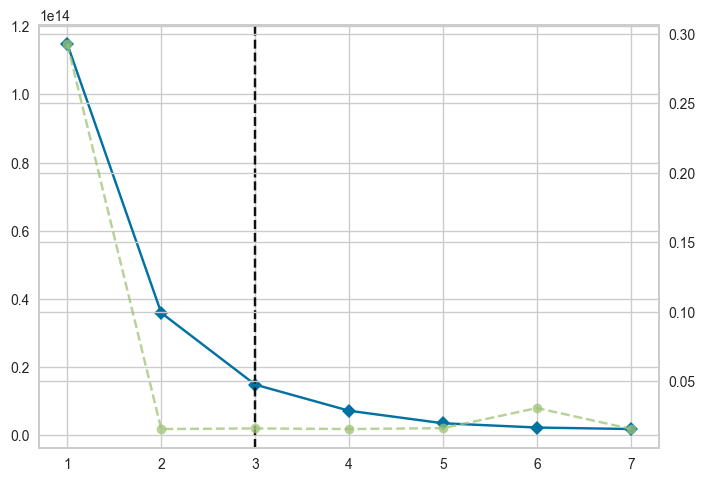

In [22]:
from yellowbrick.cluster import KElbowVisualizer


kl_grouped_clustering = kl_grouped.drop(columns=['Location'])


model = KMeans(random_state=0)
visualizer = KElbowVisualizer(model, k=(1,8))
visualizer.fit(kl_grouped_clustering)        # Fit the data to the visualizer

In [23]:
# set number of clusters
kclusters = 5

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(kl_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

c:\Users\mgree\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


array([0, 1, 2, 2, 1, 2, 2, 2, 0, 0, 4, 2, 0, 3, 4, 2, 0, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 0, 0, 2, 0, 0, 2, 2, 2, 2, 0, 2, 2, 1, 2, 2, 0, 2,
       0, 0, 0, 2])

In [24]:
#kl_grouped.drop(['Cluster Labels'], axis=1, inplace=True)
kl_grouped.insert(0, 'Cluster Labels', kmeans.labels_)

In [25]:
kl_grouped.head()

,Cluster Labels,Location,Price,Rooms,Bathrooms,Car Parks,Size,Price per Area,Price per Room,Latitude,Longitude,Type_Apartment,Type_Bungalow,Type_Cluster House,Type_Condominium,Type_Flat,Type_Residential Land,Type_Semi-detached House,Type_Serviced Residence,Type_Terrace/Link House,Type_Townhouse
0,0,ampang,1.838012e+06,3.613235,3.301471,2.229412,2810.311765,755.544420,479099.240149,3.161801,101.735361,0.010294,0.133824,0.000000,0.245588,0.002941,0.007353,0.045588,0.450000,0.086765,0.017647
1,1,ampang hilir,3.325167e+06,3.801546,3.520619,2.484536,3265.652062,987.756431,767217.288928,3.158521,101.740186,0.000000,0.051546,0.000000,0.628866,0.000000,0.000000,0.010309,0.265464,0.028351,0.015464
2,2,bandar damai perdana,7.329299e+05,4.169492,3.254237,2.389831,1507.627119,495.683396,172042.224575,3.047418,101.738603,0.000000,0.000000,0.016949,0.000000,0.000000,0.000000,0.033898,0.000000,0.779661,0.169492
3,2,bandar menjalara,7.260876e+05,3.616246,2.428571,1.770308,2764.694678,500.646333,189483.044021,3.194134,101.627228,0.016807,0.005602,0.000000,0.509804,0.000000,0.000000,0.042017,0.266106,0.154062,0.005602
4,1,bangsar,4.032569e+06,4.207117,3.840328,2.797445,3841.863139,1048.380190,860345.366424,3.130830,101.669440,0.000000,0.193431,0.000000,0.537409,0.000000,0.000912,0.015511,0.115876,0.112226,0.024635


### Show clusters on a map

In [26]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(kl_grouped['Latitude'], kl_grouped['Longitude'], kl_grouped['Location'], kl_grouped['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=15,
        popup=label,
        color=rainbow[cluster-1],
        fill=False,
        #fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

##Examine each cluster

### Cluster 0

In [27]:
kl_grouped.loc[kl_grouped['Cluster Labels'] == 0, kl_grouped.columns[[1] + list(range(2, kl_grouped.shape[1]))]]

,Location,Price,Rooms,Bathrooms,Car Parks,Size,Price per Area,Price per Room,Latitude,Longitude,Type_Apartment,Type_Bungalow,Type_Cluster House,Type_Condominium,Type_Flat,Type_Residential Land,Type_Semi-detached House,Type_Serviced Residence,Type_Terrace/Link House,Type_Townhouse
0,ampang,1.838012e+06,3.613235,3.301471,2.229412,2810.311765,755.544420,479099.240149,3.161801,101.735361,0.010294,0.133824,0.0,0.245588,0.002941,0.007353,0.045588,0.450000,0.086765,0.017647
8,bukit bintang,1.938929e+06,2.643498,2.446188,1.439462,1517.639013,1255.117161,731228.448804,3.147107,101.708601,0.013453,0.000000,0.0,0.320628,0.000000,0.000000,0.000000,0.663677,0.002242,0.000000
9,bukit jalil,1.450792e+06,3.626844,2.699607,2.037365,1817.893314,884.529571,334902.198874,3.053346,101.680294,0.095379,0.012783,0.0,0.659292,0.000000,0.000492,0.007866,0.160275,0.061947,0.001967
12,city centre,1.873873e+06,3.157623,2.850129,1.612403,2088.829457,929.859857,657674.745598,53.481522,-2.241775,0.000000,0.018088,0.0,0.583979,0.000000,0.000000,0.005168,0.390181,0.002584,0.000000
16,desa parkcity,2.267923e+06,4.064242,3.654545,2.456970,2178.429091,1097.507451,557549.648706,3.186383,101.631816,0.000000,0.019394,0.0,0.471515,0.000000,0.000000,0.026667,0.000000,0.466667,0.015758
27,kl sentral,2.140316e+06,2.841155,2.826715,1.424188,1636.382671,1313.573247,823331.321269,3.134594,101.686264,0.000000,0.001805,0.0,0.279783,0.000000,0.000000,0.000000,0.718412,0.000000,0.000000
28,klcc,2.257115e+06,2.912523,2.698776,1.599844,1842.407967,1382.803604,822412.548449,3.159310,101.713358,0.001822,0.003124,0.0,0.370997,0.000260,0.000521,0.001302,0.619370,0.001302,0.001302
30,mont kiara,1.892699e+06,3.918304,3.554145,2.191902,2357.675611,828.361283,464969.573815,3.169999,101.652147,0.000000,0.023479,0.0,0.762817,0.000000,0.000000,0.017968,0.181121,0.014135,0.000479
31,oug,2.119315e+06,4.879310,3.948276,3.879310,4366.454023,523.630284,401798.771976,3.073880,101.671606,0.000000,0.310345,0.0,0.000000,0.000000,0.000000,0.149425,0.000000,0.413793,0.126437
36,seputeh,2.498797e+06,4.278810,3.684015,2.401487,3468.401487,752.164694,500084.790808,3.113687,101.681420,0.018587,0.267658,0.0,0.550186,0.000000,0.000000,0.052045,0.040892,0.070632,0.000000


These are mostly expensive neighborhoods with large units.

### Cluster 1

In [28]:
kl_grouped.loc[kl_grouped['Cluster Labels'] == 1, kl_grouped.columns[[1] + list(range(2, kl_grouped.shape[1]))]]

,Location,Price,Rooms,Bathrooms,Car Parks,Size,Price per Area,Price per Room,Latitude,Longitude,Type_Apartment,Type_Bungalow,Type_Cluster House,Type_Condominium,Type_Flat,Type_Residential Land,Type_Semi-detached House,Type_Serviced Residence,Type_Terrace/Link House,Type_Townhouse
1,ampang hilir,3.325167e+06,3.801546,3.520619,2.484536,3265.652062,987.756431,767217.288928,3.158521,101.740186,0.0,0.051546,0.000000,0.628866,0.0,0.000000,0.010309,0.265464,0.028351,0.015464
4,bangsar,4.032569e+06,4.207117,3.840328,2.797445,3841.863139,1048.380190,860345.366424,3.130830,101.669440,0.0,0.193431,0.000000,0.537409,0.0,0.000912,0.015511,0.115876,0.112226,0.024635
39,sri hartamas,3.188067e+06,4.559917,4.338843,2.952479,3465.564050,931.572004,637054.086887,3.161846,101.650054,0.0,0.113636,0.004132,0.340909,0.0,0.000000,0.188017,0.204545,0.130165,0.018595


Country heights, Damansara stands alone as one of the most luxury neighborhood with luxury condos. This is the home of politicians, celebrities and rich people in general.

### Cluster 2

In [29]:
kl_grouped.loc[kl_grouped['Cluster Labels'] == 2, kl_grouped.columns[[1] + list(range(2, kl_grouped.shape[1]))]]

,Location,Price,Rooms,Bathrooms,Car Parks,Size,Price per Area,Price per Room,Latitude,Longitude,Type_Apartment,Type_Bungalow,Type_Cluster House,Type_Condominium,Type_Flat,Type_Residential Land,Type_Semi-detached House,Type_Serviced Residence,Type_Terrace/Link House,Type_Townhouse
2,bandar damai perdana,7.329299e+05,4.169492,3.254237,2.389831,1507.627119,495.683396,172042.224575,3.047418,101.738603,0.000000,0.000000,0.016949,0.000000,0.000000,0.000000,0.033898,0.000000,0.779661,0.169492
3,bandar menjalara,7.260876e+05,3.616246,2.428571,1.770308,2764.694678,500.646333,189483.044021,3.194134,101.627228,0.016807,0.005602,0.000000,0.509804,0.000000,0.000000,0.042017,0.266106,0.154062,0.005602
5,bangsar south,8.897530e+05,2.450000,1.903125,1.206250,1012.075000,893.373481,367623.522023,3.112973,101.666729,0.121875,0.003125,0.000000,0.178125,0.000000,0.000000,0.006250,0.681250,0.009375,0.000000
6,batu caves,6.199728e+05,2.918919,2.112613,1.761261,1116.576577,565.231861,219148.146894,3.223122,101.689382,0.054054,0.004505,0.000000,0.171171,0.004505,0.000000,0.004505,0.716216,0.045045,0.000000
7,brickfields,1.298960e+06,2.735294,2.039216,1.352941,1843.950980,715.183570,389969.521239,3.128857,101.684553,0.137255,0.029412,0.000000,0.460784,0.009804,0.000000,0.009804,0.352941,0.000000,0.000000
11,cheras,8.114027e+05,3.555595,2.629954,1.857945,1585.554192,530.992065,218241.764603,3.099192,101.737423,0.084181,0.036128,0.000000,0.434935,0.005612,0.000702,0.037531,0.180288,0.203788,0.016836
15,desa pandan,9.871434e+05,2.575221,2.070796,1.902655,1446.061947,724.178228,403996.165193,3.148269,101.738075,0.097345,0.000000,0.000000,0.000000,0.000000,0.000000,0.008850,0.884956,0.008850,0.000000
17,desa petaling,3.763140e+05,2.981308,2.084112,1.205607,982.971963,362.211036,120646.604364,3.084185,101.703552,0.317757,0.000000,0.000000,0.607477,0.046729,0.000000,0.009346,0.000000,0.018692,0.000000
18,dutamas,1.040169e+06,3.492205,2.977728,1.886414,1667.741648,630.264118,312218.774870,3.171081,101.665906,0.000000,0.004454,0.000000,0.786192,0.000000,0.001114,0.030067,0.165924,0.012249,0.000000
19,jalan bukit pantai,1.049186e+06,2.971193,2.238683,1.662551,1734.835391,588.792004,335195.812794,3.117026,101.668136,0.000000,0.057613,0.000000,0.769547,0.004115,0.000000,0.004115,0.160494,0.004115,0.000000


This is the place for people with middle income

### Cluster 3

In [30]:
kl_grouped.loc[kl_grouped['Cluster Labels'] == 3, kl_grouped.columns[[1] + list(range(2, kl_grouped.shape[1]))]]

,Location,Price,Rooms,Bathrooms,Car Parks,Size,Price per Area,Price per Room,Latitude,Longitude,Type_Apartment,Type_Bungalow,Type_Cluster House,Type_Condominium,Type_Flat,Type_Residential Land,Type_Semi-detached House,Type_Serviced Residence,Type_Terrace/Link House,Type_Townhouse
13,country heights damansara,8.464653e+06,6.428571,6.653061,4.77551,9184.836735,915.861467,1.486345e+06,3.178056,101.631221,0.0,0.836735,0.0,0.0,0.0,0.040816,0.0,0.102041,0.020408,0.0


Another expensive neighborhoods with luxury homes

### Cluster 4

In [31]:
kl_grouped.loc[kl_grouped['Cluster Labels'] == 4, kl_grouped.columns[[1] + list(range(2, kl_grouped.shape[1]))]]

,Location,Price,Rooms,Bathrooms,Car Parks,Size,Price per Area,Price per Room,Latitude,Longitude,Type_Apartment,Type_Bungalow,Type_Cluster House,Type_Condominium,Type_Flat,Type_Residential Land,Type_Semi-detached House,Type_Serviced Residence,Type_Terrace/Link House,Type_Townhouse
10,bukit tunku (kenny hills),5.891314e+06,5.175000,5.11875,3.59375,7174.525000,856.713864,9.927273e+05,3.169008,101.681096,0.031250,0.287500,0.0,0.646875,0.0,0.012500,0.021875,0.000000,0.000000,0.00000
14,damansara heights,5.140485e+06,4.778774,4.54559,3.22272,5200.532138,1086.485492,1.020633e+06,3.152395,101.658445,0.001495,0.433483,0.0,0.137519,0.0,0.001495,0.089686,0.284006,0.049327,0.00299


Neighborhoods for upper income category

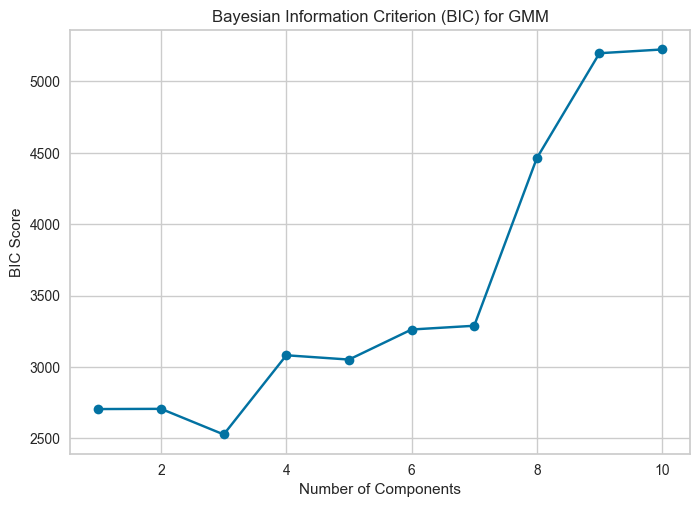

Optimal number of components: 3
### Cluster 0
Cities in this cluster:
['bandar damai perdana', 'bandar menjalara', 'bangsar south', 'batu caves', 'brickfields', 'bukit jalil', 'cheras', 'desa pandan', 'desa petaling', 'dutamas', 'jalan bukit pantai', 'jalan ipoh', 'jalan klang lama (old klang road)', 'jalan kuching', 'jalan sultan ismail', 'kampung datuk keramat', 'kepong', 'kl eco city', 'kuchai lama', 'pandan perdana', 'salak selatan', 'segambut', 'sentul', 'setapak', 'setiawangsa', 'sri petaling', 'sungai besi', 'taman desa', 'wangsa maju']
### Cluster 1
Cities in this cluster:
['bukit tunku (kenny hills)', 'country heights damansara', 'damansara heights']
### Cluster 2
Cities in this cluster:
['ampang', 'ampang hilir', 'bangsar', 'bukit bintang', 'city centre', 'desa parkcity', 'kl sentral', 'klcc', 'mont kiara', 'oug', 'seputeh', 'sri hartamas', 'sunway spk', 'taman melawati', 'taman tun dr ismail', 'titiwangsa']


In [56]:
import numpy as np
import pandas as pd
import folium
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
from matplotlib import cm, colors

# Step 3. Data analysis and clustering

# One-hot encoding
kl_onehot = pd.get_dummies(df_property, columns=["Property Type"], prefix=["Type"])

# Group rows by district and take the mean of the frequency of occurrence of each offense
kl_grouped = kl_onehot.groupby('Location').mean().reset_index()

# Clustering

# Find the optimal number of components (clusters) using Bayesian Information Criterion (BIC)
n_components = np.arange(1, 11)
bics = []

for n in n_components:
    gmm = GaussianMixture(n_components=n, random_state=0)
    gmm.fit(kl_grouped.drop(columns=['Location']))
    bics.append(gmm.bic(kl_grouped.drop(columns=['Location'])))

# Plot the BIC scores
plt.plot(n_components, bics, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('BIC Score')
plt.title('Bayesian Information Criterion (BIC) for GMM')
plt.show()

# Based on the plot, choose the optimal number of components
optimal_components = np.argmin(bics) + 1
print(f"Optimal number of components: {optimal_components}")

# Fit GMM with the optimal number of components
gmm = GaussianMixture(n_components=optimal_components, random_state=0)
gmm.fit(kl_grouped.drop(columns=['Location']))

# Predict cluster labels
gmm_labels = gmm.predict(kl_grouped.drop(columns=['Location']))

# Add cluster labels to the grouped dataframe
kl_grouped['Cluster Labels'] = gmm_labels

# Print clusters and cities
for i in range(optimal_components):
    print(f"### Cluster {i}")
    cluster_cities = kl_grouped.loc[kl_grouped['Cluster Labels'] == i, 'Location']
    print("Cities in this cluster:")
    print(cluster_cities.tolist())

# Show clusters on a map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# Set color scheme for the clusters
x = np.arange(optimal_components)
ys = [i + x + (i * x) ** 2 for i in range(optimal_components)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# Add markers to the map
for lat, lon, poi, cluster in zip(kl_grouped['Latitude'], kl_grouped['Longitude'], kl_grouped['Location'], kl_grouped['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=15,
        popup=label,
        color=rainbow[cluster - 1],
        fill=False,
        fill_opacity=0.7).add_to(map_clusters)

map_clusters


#Step 4. Foursquare data
Next let's analyse the same neighborhoods using the data obtained from Foursquare

##Foursquare crdentials

In [57]:
CLIENT_ID = 'HOGPJE3HEQSUCCOHACGSFU22DYGFV4NM3VG2WELOIHXBH0QF' # your Foursquare ID (fake)
CLIENT_SECRET = 'Y0DLYDDF2YBRYE2IITVXVPLIYZ4YAAI2VR0FEKDKZ3UDB1MA' # your Foursquare Secret
VERSION = '20200612' # Foursquare API version
LIMIT=100

## Explore KL neighborhoods

In [58]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [34]:
df_districts.head()

,District,Latitude,Longitude
0,ampang,3.161801,101.735361
1,ampang hilir,3.158521,101.740186
2,bandar damai perdana,3.047418,101.738603
3,bandar menjalara,3.194134,101.627228
4,bangsar,3.130830,101.669440


In [35]:
kl_venues = getNearbyVenues(names=df_districts['District'], latitudes=df_districts['Latitude'],longitudes=df_districts['Longitude'])

ampang
ampang hilir
bandar damai perdana
bandar menjalara
bangsar
bangsar south
batu caves
brickfields
bukit bintang
bukit jalil
bukit tunku (kenny hills)
cheras
city centre
country heights damansara
damansara heights
desa pandan
desa parkcity
desa petaling
dutamas
jalan bukit pantai
jalan ipoh
jalan klang lama (old klang road)
jalan kuching
jalan sultan ismail
kampung datuk keramat
kepong
kl eco city
kl sentral
klcc
kuchai lama
mont kiara
oug
pandan perdana
salak selatan
segambut
sentul
seputeh
setapak
setiawangsa
sri hartamas
sri petaling
sungai besi
sunway spk
taman desa
taman melawati
taman tun dr ismail
titiwangsa
wangsa maju


Let's check returned venues

In [36]:
kl_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,ampang,3.161801,101.735361,"Toys""R""Us",3.160641,101.736694,Toy Store
1,ampang,3.161801,101.735361,Boost Juice Bars,3.160645,101.736680,Juice Bar
2,ampang,3.161801,101.735361,Alexis,3.160631,101.736492,Bistro
3,ampang,3.161801,101.735361,KizSports & Gym,3.160623,101.736715,Playground
4,ampang,3.161801,101.735361,Energy Day Spa,3.160646,101.736663,Spa


Number of venues for each neighborhood

In [37]:
kl_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
ampang,28,28,28,28,28,28
ampang hilir,42,42,42,42,42,42
bandar damai perdana,23,23,23,23,23,23
bandar menjalara,59,59,59,59,59,59
bangsar,89,89,89,89,89,89
bangsar south,79,79,79,79,79,79
batu caves,17,17,17,17,17,17
brickfields,65,65,65,65,65,65
bukit bintang,56,56,56,56,56,56


In [38]:
print('There are {} uniques categories.'.format(len(kl_venues['Venue Category'].unique())))

There are 236 uniques categories.


##Analyze each neighborhood

In [39]:
# Assuming you've created the DataFrame kl_venues somewhere before
# One hot encoding
kl_venues_onehot = pd.get_dummies(kl_venues[['Venue Category']], prefix="", prefix_sep="")

# Add the 'Neighborhood' column back to the one-hot encoded DataFrame
kl_venues_onehot['Neighborhood'] = kl_venues['Neighborhood']

# Move the 'Neighborhood' column to the first position
cols = kl_venues_onehot.columns.tolist()
cols = [cols[-1]] + cols[:-1]
kl_venues_onehot = kl_venues_onehot[cols]

# Display the first few rows of the DataFrame
print(kl_venues_onehot.head())

# Now you can proceed with further analysis or processing using kl_venues_onehot


   Yemeni Restaurant  African Restaurant  American Restaurant  Amusement Park  \
0              False               False                False           False   
1              False               False                False           False   
2              False               False                False           False   
3              False               False                False           False   
4              False               False                False           False   

   Antique Store  Apartment or Condo  Arcade  Art Gallery  \
0          False               False   False        False   
1          False               False   False        False   
2          False               False   False        False   
3          False               False   False        False   
4          False               False   False        False   

   Arts and Crafts Store  Arts and Entertainment  Asian Restaurant  \
0                  False                   False             False   
1     

In [40]:
kl_venues_onehot.shape

(1899, 236)

Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [41]:
print(kl_venues_onehot['Neighborhood'].shape)
print(kl_venues_onehot['Neighborhood'].unique())

kl_venues_grouped = kl_venues_onehot.groupby('Neighborhood').mean().reset_index()
kl_venues_grouped


(1899,)
['ampang' 'ampang hilir' 'bandar damai perdana' 'bandar menjalara'
 'bangsar' 'bangsar south' 'batu caves' 'brickfields' 'bukit bintang'
 'bukit jalil' 'bukit tunku (kenny hills)' 'cheras' 'city centre'
 'country heights damansara' 'damansara heights' 'desa pandan'
 'desa parkcity' 'desa petaling' 'dutamas' 'jalan bukit pantai'
 'jalan ipoh' 'jalan klang lama (old klang road)' 'jalan kuching'
 'jalan sultan ismail' 'kampung datuk keramat' 'kepong' 'kl eco city'
 'kl sentral' 'klcc' 'kuchai lama' 'mont kiara' 'oug' 'pandan perdana'
 'salak selatan' 'segambut' 'sentul' 'seputeh' 'setapak' 'setiawangsa'
 'sri hartamas' 'sri petaling' 'sungai besi' 'sunway spk' 'taman desa'
 'taman melawati' 'taman tun dr ismail' 'titiwangsa' 'wangsa maju']


,Neighborhood,Yemeni Restaurant,African Restaurant,American Restaurant,Amusement Park,Antique Store,Apartment or Condo,Arcade,Art Gallery,Arts and Crafts Store,Arts and Entertainment,Asian Restaurant,Automotive Repair Shop,BBQ Joint,Bagel Shop,Bakery,Bar,Bed and Breakfast,Beer Bar,Beer Garden,Belgian Restaurant,Betting Shop,Bistro,Boat or Ferry,Bookstore,Border Crossing,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Store,Bubble Tea Shop,Buffet,Burger Joint,Burrito Restaurant,Bus Station,Cafeteria,Café,Cajun and Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Casino,Castle,Children's Clothing Store,Chinese Breakfast Restaurant,Chinese Restaurant,Chocolate Store,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Bookstore,College Quad,Comedy Club,Comic Book Store,Concert Hall,Convenience Store,Convention Center,Cosmetics Store,Cupcake Shop,Deli,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Doctor's Office,Dog Park,Donut Shop,Dumpling Restaurant,Electronics Store,English Restaurant,Escape Room,Event Space,Eyecare Store,Farmers Market,Fashion Accessories Store,Fast Food Restaurant,Fish Market,Fish and Chips Shop,Fishing Store,Flea Market,Flower Store,Food Court,Food Stand,Food Truck,Food and Beverage Retail,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit and Vegetable Store,Fuel Station,Furniture and Home Store,Gaming Cafe,Gift Store,Gourmet Store,Grocery Store,Hainan Restaurant,Hair Salon,Hakka Restaurant,Halal Restaurant,Hawaiian Restaurant,Hiking Trail,Historic and Protected Site,History Museum,Hockey Stadium,Hong Kong Restaurant,Hookah Bar,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Housing Development,Hunan Restaurant,Ice Cream Parlor,Indian Chinese Restaurant,Indian Restaurant,Indonesian Restaurant,Internet Cafe,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Kitchen Supply Store,Korean BBQ Restaurant,Korean Restaurant,Latin American Restaurant,Light Rail Station,Lingerie Store,Lounge,Malay Restaurant,Mamak Restaurant,Market,Massage Clinic,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Store,Mobile Phone Store,Modern European Restaurant,Monument,Mosque,Motorcycle Dealership,Movie Theater,Music School,Music Store,Music Venue,Night Club,Noodle Restaurant,North Indian Restaurant,Office Supply Store,Other Great Outdoors,Padangnese Restaurant,Pakistani Restaurant,Park,Parking,Performing Arts Venue,Persian Restaurant,Pet Café,Pet Supplies Store,Pharmacy,Pie Shop,Pizzeria,Playground,Plaza,Poke Restaurant,Police Station,Pool Hall,Portuguese Restaurant,Print Store,Pub,Rail Station,Ramen Restaurant,Record Store,Rest Area,Restaurant,Rock Club,Sake Bar,Salad Restaurant,Sandwich Spot,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Smoke Shop,Snack Place,Soccer Field,Soup Spot,South American Restaurant,South Indian Restaurant,Spa,Spanish Restaurant,Speakeasy,Spiritual Center,Sporting Goods Retail,Sports Bar,Sri Lankan Restaurant,Stadium,Stationery Store,Steakhouse,Street Food Gathering,Structure,Supermarket,Sushi Restaurant,Swimming Pool,Szechuan Restaurant,Taco Restaurant,Taiwanese Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Toy Store,Track,Travel Agency,Turkish Restaurant,Udon Restaurant,Vape Store,Vegan and Vegetarian Restaurant,Vietnamese Restaurant,Vintage and Thrift Store,Warehouse or Wholesale Store,Whisky Bar,Wine Bar,Wine Store,Women's Store
0,ampang,0.035714,0.000000,0.035714,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.035714,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.035714,0.000000,0.000000,0.000000,0.035714,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.142857,0.035714,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0

Let's print each neighborhood along with the top 5 most common venues

In [59]:
num_top_venues = 5

for hood in kl_venues_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = kl_venues_grouped[kl_venues_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----ampang----
                 venue  freq
0                 Café  0.14
1          Coffee Shop  0.11
2  Japanese Restaurant  0.07
3                  Spa  0.07
4    Yemeni Restaurant  0.04


----ampang hilir----
                         venue  freq
0                         Café  0.17
1                  Coffee Shop  0.14
2                Sandwich Spot  0.05
3  Cajun and Creole Restaurant  0.05
4          Japanese Restaurant  0.05


----bandar damai perdana----
                venue  freq
0  Chinese Restaurant  0.30
1    Asian Restaurant  0.17
2          Restaurant  0.09
3     Thai Restaurant  0.04
4      Breakfast Spot  0.04


----bandar menjalara----
                             venue  freq
0               Chinese Restaurant  0.20
1                 Asian Restaurant  0.08
2                             Café  0.07
3                 Malay Restaurant  0.07
4  Vegan and Vegetarian Restaurant  0.07


----bangsar----
                venue  freq
0   Indian Restaurant  0.13
1     Cosmetics Stor

##Create a new df for top 10 neighborhoods

In [43]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [44]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = kl_venues_grouped['Neighborhood']

for ind in np.arange(kl_venues_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(kl_venues_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,ampang,Café,Coffee Shop,Japanese Restaurant,Spa,Yemeni Restaurant,Sushi Restaurant,Boutique,Shopping Mall,Grocery Store,Bistro
1,ampang hilir,Café,Coffee Shop,Sandwich Spot,Cajun and Creole Restaurant,Japanese Restaurant,Yemeni Restaurant,Sushi Restaurant,Burger Joint,Sporting Goods Retail,Spa
2,bandar damai perdana,Chinese Restaurant,Asian Restaurant,Restaurant,Thai Restaurant,Breakfast Spot,Office Supply Store,Grocery Store,Mamak Restaurant,Performing Arts Venue,College Bookstore
3,bandar menjalara,Chinese Restaurant,Asian Restaurant,Café,Malay Restaurant,Vegan and Vegetarian Restaurant,Noodle Restaurant,Japanese Restaurant,Seafood Restaurant,Fuel Station,Pizzeria
4,bangsar,Indian Restaurant,Cosmetics Store,Steakhouse,Chinese Restaurant,Ice Cream Parlor,Bar,Coffee Shop,Café,Juice Bar,Clothing Store


#Step 5. Clustering based on venues

In [45]:
if 'Neighborhood' in kl_venues_grouped.columns:
    kl_venues_grouped_clustering = kl_venues_grouped.drop('Neighborhood', axis=1)
    # run k-means clustering
    kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(kl_venues_grouped_clustering)
    # check cluster labels generated for each row in the dataframe
    print(kmeans.labels_)
else:
    print("'Neighborhood' column not found in kl_venues_grouped DataFrame.")


[1 1 0 0 1 1 4 1 1 1 2 0 1 1 1 4 1 0 1 4 0 0 1 1 4 0 1 1 1 0 1 0 0 0 1 0 1
 0 1 1 1 1 3 1 4 1 1 1]


c:\Users\mgree\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [46]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

kl_venues_merged = df_districts

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
kl_venues_merged = kl_venues_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='District')

kl_venues_merged.head() # check the last columns!

,District,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,ampang,3.161801,101.735361,1,Café,Coffee Shop,Japanese Restaurant,Spa,Yemeni Restaurant,Sushi Restaurant,Boutique,Shopping Mall,Grocery Store,Bistro
1,ampang hilir,3.158521,101.740186,1,Café,Coffee Shop,Sandwich Spot,Cajun and Creole Restaurant,Japanese Restaurant,Yemeni Restaurant,Sushi Restaurant,Burger Joint,Sporting Goods Retail,Spa
2,bandar damai perdana,3.047418,101.738603,0,Chinese Restaurant,Asian Restaurant,Restaurant,Thai Restaurant,Breakfast Spot,Office Supply Store,Grocery Store,Mamak Restaurant,Performing Arts Venue,College Bookstore
3,bandar menjalara,3.194134,101.627228,0,Chinese Restaurant,Asian Restaurant,Café,Malay Restaurant,Vegan and Vegetarian Restaurant,Noodle Restaurant,Japanese Restaurant,Seafood Restaurant,Fuel Station,Pizzeria
4,bangsar,3.130830,101.669440,1,Indian Restaurant,Cosmetics Store,Steakhouse,Chinese Restaurant,Ice Cream Parlor,Bar,Coffee Shop,Café,Juice Bar,Clothing Store


##Create a clusters map

In [47]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(kl_venues_merged['Latitude'], kl_venues_merged['Longitude'], kl_venues_merged['District'], kl_venues_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

##Lets analyse each cluster

###Cluster 0

In [48]:
kl_venues_merged.loc[kl_venues_merged['Cluster Labels'] == 0, kl_venues_merged.columns[[0] + list(range(4, kl_venues_merged.shape[1]))]]

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,bandar damai perdana,Chinese Restaurant,Asian Restaurant,Restaurant,Thai Restaurant,Breakfast Spot,Office Supply Store,Grocery Store,Mamak Restaurant,Performing Arts Venue,College Bookstore
3,bandar menjalara,Chinese Restaurant,Asian Restaurant,Café,Malay Restaurant,Vegan and Vegetarian Restaurant,Noodle Restaurant,Japanese Restaurant,Seafood Restaurant,Fuel Station,Pizzeria
11,cheras,Chinese Restaurant,Seafood Restaurant,Japanese Restaurant,Thai Restaurant,Asian Restaurant,Steakhouse,Snack Place,Breakfast Spot,Fast Food Restaurant,Bubble Tea Shop
17,desa petaling,Chinese Restaurant,Seafood Restaurant,Asian Restaurant,Thai Restaurant,Other Great Outdoors,Convenience Store,Steakhouse,Malay Restaurant,Furniture and Home Store,Dumpling Restaurant
20,jalan ipoh,Chinese Restaurant,Café,Fuel Station,Cosmetics Store,Food Truck,Convenience Store,Camera Store,Asian Restaurant,Bowling Alley,Spa
21,jalan klang lama (old klang road),Thai Restaurant,Fuel Station,Chinese Restaurant,Japanese Restaurant,Vegan and Vegetarian Restaurant,Chinese Breakfast Restaurant,Music Store,Music School,Music Venue,Movie Theater
25,kepong,Chinese Restaurant,Asian Restaurant,Noodle Restaurant,Café,Coffee Shop,Dessert Shop,Fishing Store,Tea Room,Seafood Restaurant,Cafeteria
29,kuchai lama,Chinese Restaurant,Fuel Station,Convenience Store,Coffee Shop,Hotpot Restaurant,Dessert Shop,Malay Restaurant,Thai Restaurant,Asian Restaurant,Beer Bar
31,oug,Chinese Restaurant,Asian Restaurant,Pharmacy,Noodle Restaurant,Café,Cantonese Restaurant,Bakery,Malay Restaurant,Vegan and Vegetarian Restaurant,Coffee Shop
32,pandan perdana,Chinese Restaurant,Convenience Store,Indonesian Restaurant,Electronics Store,Spa,Fuel Station,Candy Store,Malay Restaurant,Seafood Restaurant,Eyecare Store


### Cluster 1

In [49]:
kl_venues_merged.loc[kl_venues_merged['Cluster Labels'] == 1, kl_venues_merged.columns[[0] + list(range(4, kl_venues_merged.shape[1]))]]

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,ampang,Café,Coffee Shop,Japanese Restaurant,Spa,Yemeni Restaurant,Sushi Restaurant,Boutique,Shopping Mall,Grocery Store,Bistro
1,ampang hilir,Café,Coffee Shop,Sandwich Spot,Cajun and Creole Restaurant,Japanese Restaurant,Yemeni Restaurant,Sushi Restaurant,Burger Joint,Sporting Goods Retail,Spa
4,bangsar,Indian Restaurant,Cosmetics Store,Steakhouse,Chinese Restaurant,Ice Cream Parlor,Bar,Coffee Shop,Café,Juice Bar,Clothing Store
5,bangsar south,Coffee Shop,Café,Restaurant,Malay Restaurant,Japanese Restaurant,Italian Restaurant,Bubble Tea Shop,Asian Restaurant,Convenience Store,Thai Restaurant
7,brickfields,Indian Restaurant,Hotel,Coffee Shop,Convenience Store,Chinese Restaurant,Café,Hostel,Malay Restaurant,Food Court,South Indian Restaurant
8,bukit bintang,Hotel,Café,Asian Restaurant,Coffee Shop,Ice Cream Parlor,Japanese Restaurant,Spa,Chinese Restaurant,Malay Restaurant,Department Store
9,bukit jalil,Japanese Restaurant,Café,Coffee Shop,Korean Restaurant,Asian Restaurant,Chinese Restaurant,Snack Place,Bar,Taiwanese Restaurant,Bistro
12,city centre,Coffee Shop,Café,Bar,Pub,Hotel,Plaza,Italian Restaurant,Bookstore,Record Store,Clothing Store
13,country heights damansara,Tea Room,Hiking Trail,Art Gallery,Light Rail Station,Yemeni Restaurant,North Indian Restaurant,Padangnese Restaurant,Other Great Outdoors,Office Supply Store,Night Club
14,damansara heights,Café,Italian Restaurant,Thai Restaurant,Speakeasy,Food and Beverage Retail,Snack Place,Chinese Restaurant,Shopping Plaza,Club House,Cocktail Bar


### Cluster 2

In [50]:
kl_venues_merged.loc[kl_venues_merged['Cluster Labels'] == 2, kl_venues_merged.columns[[0] + list(range(4, kl_venues_merged.shape[1]))]]

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
10,bukit tunku (kenny hills),Stadium,Café,Casino,Pool Hall,Irish Pub,Italian Restaurant,Music School,Music Store,Music Venue,Intersection


### Clusters and 4

In [51]:
kl_venues_merged.loc[kl_venues_merged['Cluster Labels'] == 3, kl_venues_merged.columns[[0] + list(range(4, kl_venues_merged.shape[1]))]]

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
42,sunway spk,Castle,Diner,Park,Yemeni Restaurant,Movie Theater,Music School,Music Store,Music Venue,Night Club,Noodle Restaurant


In [52]:
kl_venues_merged.loc[kl_venues_merged['Cluster Labels'] == 4, kl_venues_merged.columns[[0] + list(range(4, kl_venues_merged.shape[1]))]]

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,batu caves,Malay Restaurant,Thai Restaurant,Restaurant,Grocery Store,Hookah Bar,Coffee Shop,Caribbean Restaurant,Flea Market,Asian Restaurant,Food Truck
15,desa pandan,Malay Restaurant,Asian Restaurant,Coffee Shop,Food Truck,Travel Agency,Burger Joint,Noodle Restaurant,Fuel Station,Steakhouse,Chinese Restaurant
19,jalan bukit pantai,Coffee Shop,Asian Restaurant,Convenience Store,Malay Restaurant,Café,Print Store,Hotel,Convention Center,Hockey Stadium,Food Court
24,kampung datuk keramat,Thai Restaurant,Malay Restaurant,Asian Restaurant,Hotel,Breakfast Spot,Gourmet Store,Taco Restaurant,Seafood Restaurant,Indonesian Restaurant,Café
44,taman melawati,Malay Restaurant,Boutique,Asian Restaurant,Clothing Store,Cosmetics Store,Arcade,Food Truck,Convenience Store,Food Stand,Thai Restaurant


#Step 6. Compare two clustering results

## Create markers for KL venues clustering
Inner circle indicates clustering by Neighborhood venues

In [53]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(kl_venues_merged['Latitude'], kl_venues_merged['Longitude'], kl_venues_merged['District'], kl_venues_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)       

## Create markers for KL property clustering
Outer circles indicate the clustering by Property prices

In [54]:
# create map
#map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(kl_grouped['Latitude'], kl_grouped['Longitude'], kl_grouped['Location'], kl_grouped['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
        color=rainbow[cluster-1],
        fill=False,
        #fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [63]:
import pandas as pd
import folium

# Initialize an empty DataFrame to store filtered properties
filtered_properties = pd.DataFrame()

# User input section
print("Please enter your preferences:")
for feature in df_property.columns:
    if feature not in ['Latitude', 'Longitude', 'Location']:
        min_value = df_property[feature].min()
        max_value = df_property[feature].max()
        
        # Determine input type based on feature data type
        input_type = int if df_property[feature].dtype == 'int64' else str
        
        # Prompt user for input
        user_input = input(f"Enter your desired {feature} (between {min_value} and {max_value}): ")
        
        # Check if user provided input
        if user_input:
            # Convert input to appropriate type
            user_input = input_type(user_input)
            
            # Filter DataFrame based on user input
            if feature == 'Price':
                filtered_properties = df_property[df_property[feature] <= user_input]
            else:
                # For categorical features, directly filter the DataFrame
                filtered_properties = df_property[df_property[feature] == user_input]

# Create markers for user preferences
for lat, lon, feature_value, district in zip(filtered_properties['Latitude'], filtered_properties['Longitude'], 
                                             filtered_properties[feature], filtered_properties['Location']):
    label = folium.Popup(f"{feature}: {feature_value} | District: {district}", parse_html=True)
    folium.Marker(
        location=[lat, lon],
        popup=label,
        icon=folium.Icon(color='green', icon='home')
    ).add_to(map_clusters)

# Display the map
map_clusters


Please enter your preferences:


# Conclusion

In conclusion, we can say that neighborhoods with similar property types/values are very similar in terms of venues around that neighborhood. 

This map could be good visual tool for someone who is planning to relocate within KL city boundaries as it shows the relation between the neighborhood and venues around it.